<a href="https://colab.research.google.com/github/MatheusBigg/datascience_cats_dogs_MobileNetV2/blob/main/cats_dogs_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import os
import math
import zipfile
import shutil
import random
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import files

In [3]:
#Upload do dataset

local_zip = "kagglecatsanddogs_5340.zip"
uploaded = files.upload()
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/cats_and_dogs_raw")

Saving kagglecatsanddogs_5340.zip to kagglecatsanddogs_5340.zip


In [4]:
# Download dataset e prepraracao

# Upado
base_path = Path("/content/cats_and_dogs_raw/PetImages")
cat_dir = base_path / "Cat"
dog_dir = base_path / "Dog"

# Separando
train_dir = Path("/content/cats_and_dogs/train")
val_dir = Path("/content/cats_and_dogs/validation")

(train_dir / "Cat").mkdir(parents=True, exist_ok=True)
(train_dir / "Dog").mkdir(parents=True, exist_ok=True)
(val_dir / "Cat").mkdir(parents=True, exist_ok=True)
(val_dir / "Dog").mkdir(parents=True, exist_ok=True)

validation_split = 0.2

def split_data(source_dir, train_dest, val_dest, split):
    files = list(source_dir.glob("*.jpg"))
    random.shuffle(files)
    split_idx = int(len(files) * (1 - split))
    train_files = files[:split_idx]
    val_files = files[split_idx:]
    # Copiar arquivos
    for f in train_files:
        shutil.copy(f, train_dest / f.name)
    for f in val_files:
        shutil.copy(f, val_dest / f.name)

split_data(cat_dir, train_dir/"Cat", val_dir/"Cat", validation_split)
split_data(dog_dir, train_dir/"Dog", val_dir/"Dog", validation_split)

In [5]:
def count_images(folder):
    for category in ["Cat", "Dog"]:
        cat_path = Path(folder) / category
        num_images = len(list(cat_path.glob("*.jpg")))
        print(f"{folder}/{category}: {num_images} imagens")


# Datacleaning imagens
def remove_corrupt_images(folder):
    num_removed = 0
    for category in ["Cat", "Dog"]:
        img_dir = Path(folder) / category
        for img_path in img_dir.iterdir():
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError):
                print(f"Removendo imagem corrompida: {img_path}")
                img_path.unlink()
                num_removed += 1
    print(f"Total de imagens removidas em {folder}: {num_removed}")

# Contar imagens RAW
count_images(train_dir)
count_images(val_dir)

# Remover corrompidas
remove_corrupt_images(train_dir)
remove_corrupt_images(val_dir)

#Contar imagens CLEAN
count_images(train_dir)
count_images(val_dir)


/content/cats_and_dogs/train/Cat: 10000 imagens
/content/cats_and_dogs/train/Dog: 10000 imagens
/content/cats_and_dogs/validation/Cat: 2500 imagens
/content/cats_and_dogs/validation/Dog: 2500 imagens
Removendo imagem corrompida: /content/cats_and_dogs/train/Cat/666.jpg
Removendo imagem corrompida: /content/cats_and_dogs/train/Dog/11702.jpg
Total de imagens removidas em /content/cats_and_dogs/train: 2


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Total de imagens removidas em /content/cats_and_dogs/validation: 0
/content/cats_and_dogs/train/Cat: 9999 imagens
/content/cats_and_dogs/train/Dog: 9999 imagens
/content/cats_and_dogs/validation/Cat: 2500 imagens
/content/cats_and_dogs/validation/Dog: 2500 imagens


In [6]:
# Geradores

IMG_SIZE = (224, 224)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Gerador de validação só com preprocess_input
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    directory=str(train_dir),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=str(val_dir),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
# Modelo

#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congela as camadas do ResNet


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') #sigmoid para uma unica probabilidade
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy', #Eh cachorro ou nao (gato)
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Treinamento Inicial

EPOCHS = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    "best_model.keras", monitor="val_loss", save_best_only=True, verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9591 - loss: 0.1024
Epoch 1: val_loss improved from inf to 0.03955, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 1390s 4s/step - accuracy: 0.9592 - loss: 0.1023 - val_accuracy: 0.9846 - val_loss: 0.0396
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9804 - loss: 0.0544
Epoch 2: val_loss improved from 0.03955 to 0.03001, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 1453s 5s/step - accuracy: 0.9804 - loss: 0.0544 - val_accuracy: 0.9880 - val_loss: 0.0300
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9839 - loss: 0.0431
Epoch 3: val_loss improved from 0.03001 to 0.02988, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 1402s 4s/step - accuracy: 0.9839 - loss: 0.0431 - val_accuracy: 0.9886 - val_loss: 0.0299
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9835 - loss: 0.0454
Epoch 4: val_loss did not improve from 0.02988
313/3

In [9]:
#Fine tuning
base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

early_stop_ft = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop_ft]
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2009s 6s/step - accuracy: 0.9417 - loss: 0.1484 - val_accuracy: 0.9882 - val_loss: 0.0283
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1972s 6s/step - accuracy: 0.9773 - loss: 0.0597 - val_accuracy: 0.9888 - val_loss: 0.0254
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1939s 6s/step - accuracy: 0.9794 - loss: 0.0505 - val_accuracy: 0.9888 - val_loss: 0.0259
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1974s 6s/step - accuracy: 0.9822 - loss: 0.0468 - val_accuracy: 0.9888 - val_loss: 0.0275
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1991s 6s/step - accuracy: 0.9866 - loss: 0.0374 - val_accuracy: 0.9898 - val_loss: 0.0255


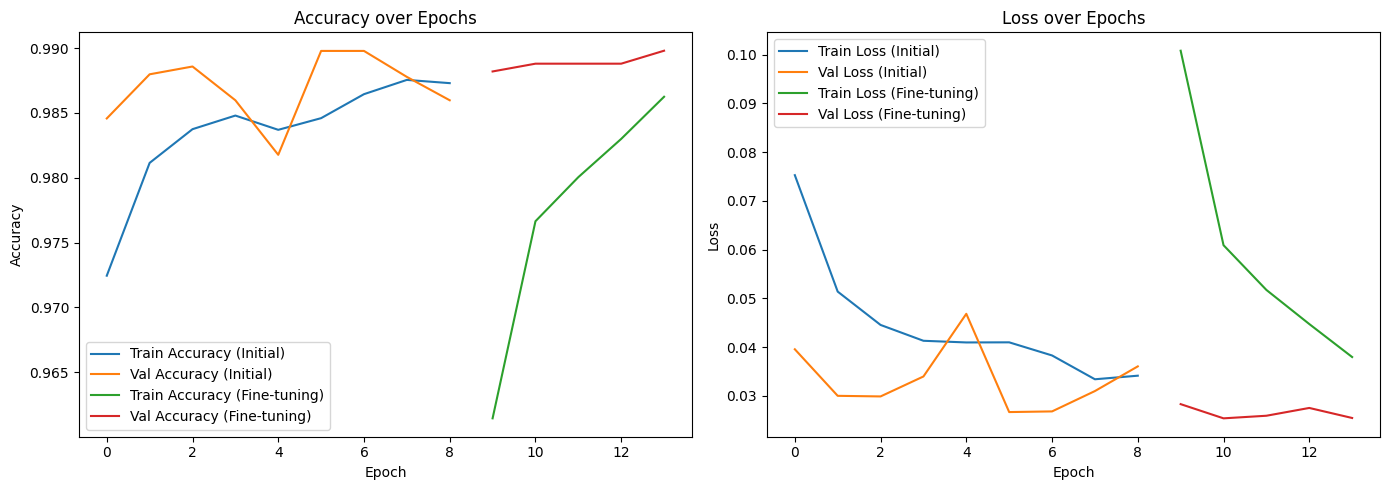

In [10]:
# Resultados do primeiro treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Resultados do fine-tuning
ft_acc = history_finetune.history['accuracy']
ft_val_acc = history_finetune.history['val_accuracy']
ft_loss = history_finetune.history['loss']
ft_val_loss = history_finetune.history['val_loss']

total_epochs = range(len(acc) + len(ft_acc))

# Gráficos
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Train Accuracy (Initial)')
plt.plot(range(len(acc)), val_acc, label='Val Accuracy (Initial)')
plt.plot(range(len(acc), len(acc)+len(ft_acc)), ft_acc, label='Train Accuracy (Fine-tuning)')
plt.plot(range(len(acc), len(acc)+len(ft_val_acc)), ft_val_acc, label='Val Accuracy (Fine-tuning)')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Train Loss (Initial)')
plt.plot(range(len(loss)), val_loss, label='Val Loss (Initial)')
plt.plot(range(len(loss), len(loss)+len(ft_loss)), ft_loss, label='Train Loss (Fine-tuning)')
plt.plot(range(len(loss), len(loss)+len(ft_val_loss)), ft_val_loss, label='Val Loss (Fine-tuning)')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()